In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_participants
from hmpai.pytorch.utilities import set_global_seed
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.pytorch.normalization import *
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.pytorch.training import train_and_test
import matplotlib.pyplot as plt
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
# Load in t1, t2 and cmb
t1_path = DATA_PATH / "prp/stage_data_250hz_t1.tmp.nc"
t2_path = DATA_PATH / "prp/stage_data_250hz_t2.tmp.nc"
cmb_path = DATA_PATH / "prp/Data_trial_250Hz.tmp.nc"

t1 = xr.open_dataset(t1_path)
t2 = xr.open_dataset(t2_path)
cmb = xr.open_dataset(cmb_path)

In [3]:
SHORT_DELAY = 300 #ms
LONG_DELAY = 1200 #ms
SAMPLING_FREQUENCY = 250 #hz

SHORT_PADDING = int((SHORT_DELAY / 1000) * SAMPLING_FREQUENCY)
LONG_PADDING = int((LONG_DELAY / 1000) * SAMPLING_FREQUENCY)

In [39]:
t1['trial_index'] == 1.0

<xarray.DataArray 'trial_index' (participant: 21, epochs: 1315)> Size: 28kB
array([[False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False]])
Coordinates:
  * epochs       (epochs) int32 5kB 0 1 2 3 4 5 ... 1310 1311 1312 1313 1315
    rt           (participant, epochs) float64 221kB ...
    condition    (participant, epochs) <U5 552kB ...
    trial_index  (participant, epochs) float64 221kB 0.0 1.0 2.0 ... nan nan nan
  * participant  (participant) <U4 336B 'VP10' 'VP11' 'VP12' ... 'VP8' 'VP9'

In [ ]:
t1.sel(participant='VP10', channels='Fp1')

In [4]:
# Check if t1 and t2 align
# Manually adjust vertical to correct for baseline referencing
# Use this to figure out delay
def plot_epoch(epoch, delay, vertical=0, participant='VP10'):
    t1_data = t1.sel(participant=participant, channels='Fp1')
    t1_data = t1_data.where(t1_data['trial_index'] == epoch, drop=True)
    t2_data = t2.sel(participant=participant, channels='Fp1')
    t2_data = t2_data.where(t2_data['trial_index'] == epoch, drop=True)
    cmb_data = cmb.sel(participant=participant, channels='Fp1')
    cmb_data = cmb_data.where(cmb_data['trial_index'] == epoch, drop=True)

    plt.title(f"{participant}, {str(epoch)}, {t1_data.condition.item()}, {t2_data.condition.item()}, {cmb_data.condition.item()}")
    plt.plot(cmb_data.data.squeeze(), label='cmb')
    plt.plot(t1_data.data.squeeze(), label='t1')
    plt.plot(range(delay, len(t2_data.samples) + delay), t2_data.data.squeeze() + vertical, label='t2')
    plt.legend()
    plt.show()

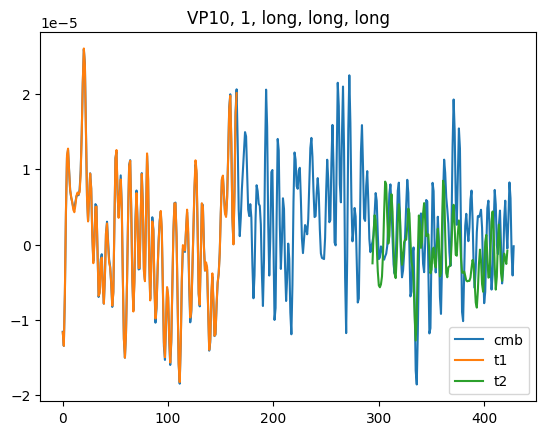

In [5]:
# Lines up with CMB, LONG_PADDING is -6
plot_epoch(1, LONG_PADDING - 6, vertical=0)

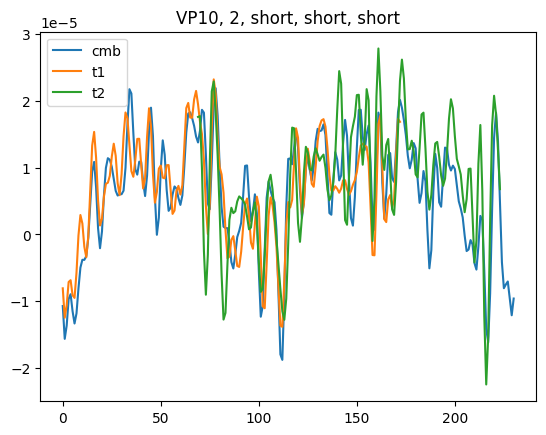

In [6]:
# Lines up with t1, SHORT PADDING is 6 less
plot_epoch(2, SHORT_PADDING - 6, 0.000007)

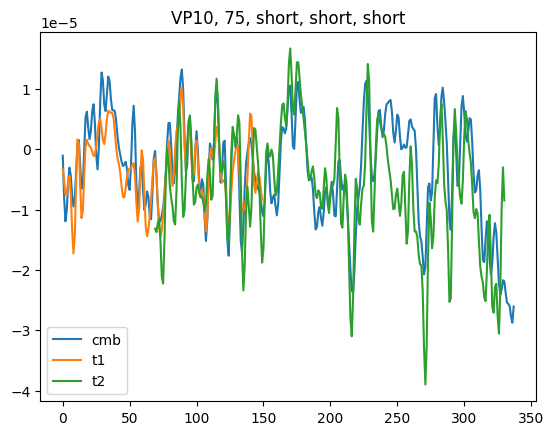

In [7]:
# Doesn't line up with t1
plot_epoch(75, SHORT_PADDING - 6, vertical=-0.000005)


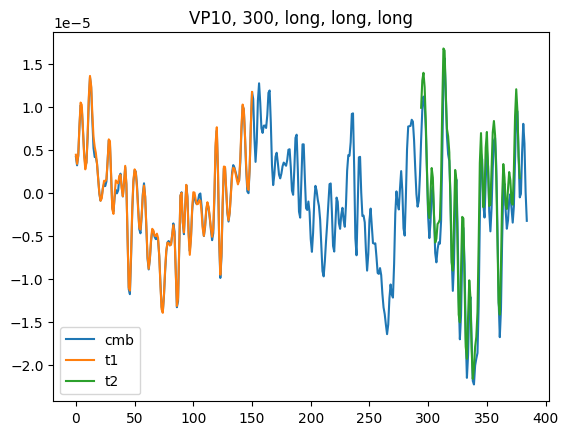

In [8]:
plot_epoch(300, LONG_PADDING - 6, vertical=0)

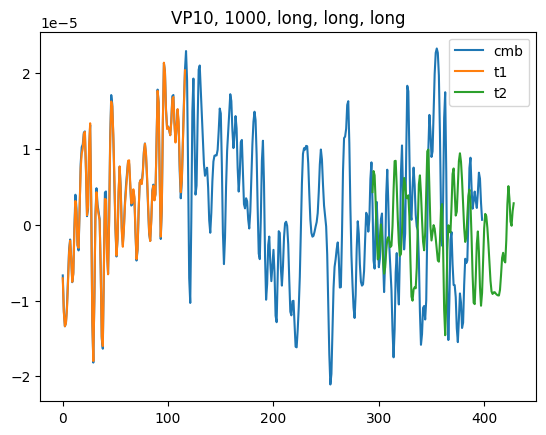

In [9]:
plot_epoch(1000, LONG_PADDING - 6, participant='VP10')


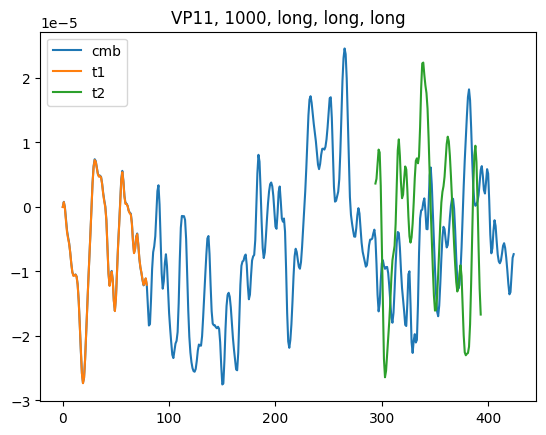

In [16]:
plot_epoch(1000, LONG_PADDING - 6, participant='VP11', vertical=-0.00001)


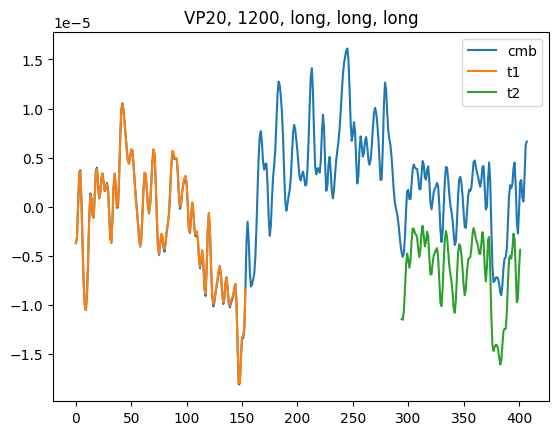

In [11]:
plot_epoch(1200, LONG_PADDING - 6, participant='VP20')

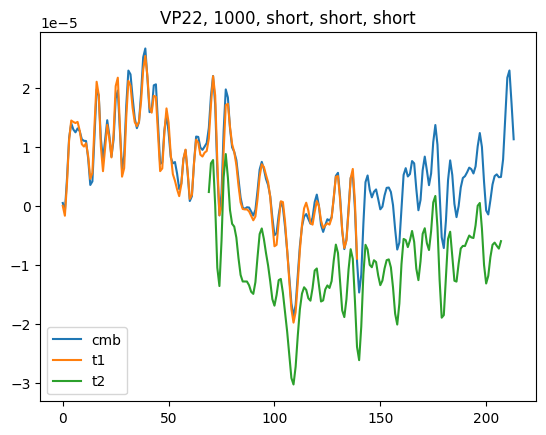

In [113]:
plot_epoch(1000, SHORT_PADDING - 6, participant='VP22')


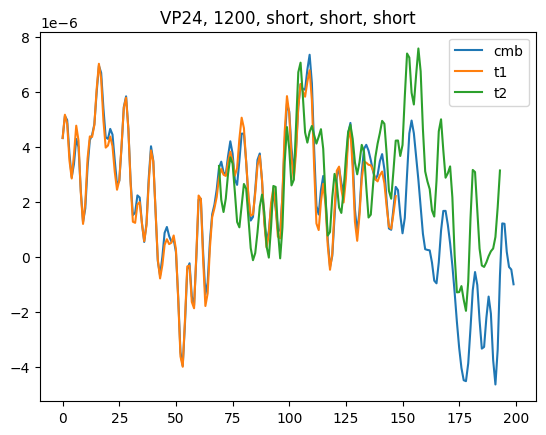

In [118]:
plot_epoch(1200, SHORT_PADDING - 6, participant='VP24', vertical=0)
